In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('seaborn-white')
# colorblind safe
plt.style.use('seaborn-colorblind')
plt.style.use('tableau-colorblind10')

# width and precision for f strings
width = 10
precision = 4

# default sizes for plots
# https://matplotlib.org/3.3.0/tutorials/introductory/customizing.html#customizing-with-matplotlibrc-files
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['lines.linewidth'] = 2

# other settings
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option("display.precision", 3)
np.set_printoptions(precision=3, suppress=True)
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)
%config IPCompleter.greedy=True


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [7]:
data = pd.read_csv('../data/USdata_est_campgrounds_zip_states_combined_cleaned.csv')
data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [10]:
# maybe just do for state subset I have images for
states = ['CO', 'CA', 'AZ', 'OR', 'UT', 'WA']
data_states = data[data['State'].isin(states)].copy()

In [153]:
len(data_states)

5363

In [13]:
data_states.groupby(['State'])['Description'].agg('count')

State
AZ     886
CA    1698
CO     707
OR     729
UT     651
WA     692
Name: Description, dtype: int64

In [14]:
data_states.groupby(['Category'])['Description'].agg('count')

Category
Eco-Friendly                16
Established Campground    1408
Informal Campsite          887
Short-term Parking          11
Showers                    139
Water                      253
Wild Camping              2649
Name: Description, dtype: int64

In [23]:
data_states = data_states[~data_states['Description'].isna()]

In [145]:
data_states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5363 entries, 0 to 12411
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Location                   1077 non-null   object 
 1   Name                       5363 non-null   object 
 2   Category                   5363 non-null   object 
 3   Description                5363 non-null   object 
 4   Latitude                   5363 non-null   float64
 5   Longitude                  5363 non-null   float64
 6   Altitude                   5276 non-null   float64
 7   Date verified              5363 non-null   object 
 8   Open                       5363 non-null   object 
 9   Electricity                4944 non-null   object 
 10  Wifi                       4944 non-null   object 
 11  Kitchen                    4944 non-null   object 
 12  Parking                    0 non-null      float64
 13  Restaurant                 4944 non-null   obje

In [24]:
descriptions = data_states['Description']

In [70]:
tfidf = TfidfVectorizer()
desc_tfidf_matrix = tfidf.fit_transform(data_states['Description'])

In [71]:
# desc_tfidf_matrix.todense() what does this do?

In [72]:
# features = tfidf.vocabulary_.keys()
# or better:
features = tfidf.get_feature_names()
len(features)

9766

In [73]:
km = KMeans(6)
y = km.fit_predict(desc_tfidf_matrix)

In [74]:
km.cluster_centers_

array([[0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.002, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.003, 0.001, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.001, 0.001, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.014, 0.   , 0.   , ..., 0.   , 0.   , 0.001],
       [0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [75]:
km.labels_

array([2, 0, 4, ..., 1, 0, 1], dtype=int32)

In [76]:
silhouette_score(desc_tfidf_matrix, labels=y)

0.0054440912977261864

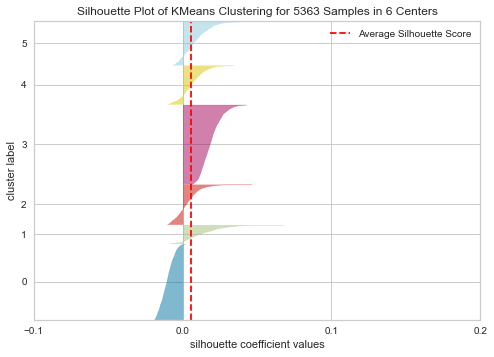

In [77]:
from yellowbrick.cluster import silhouette_visualizer
silhouette_visualizer(km, desc_tfidf_matrix, colors='yellowbrick');

In [78]:
top_10_centroids = km.cluster_centers_.argsort()[:,-1:-11:-1]
top_10_centroids

array([[8607, 6003, 8728, 7326, 1013, 3679, 6915, 5838, 4568, 6047],
       [9392, 8215, 8607, 6693, 1013, 3092, 3750, 4401, 3540, 8728],
       [3566, 1880, 9610, 6536, 1013, 7876, 8607, 3691, 6003, 7312],
       [8607, 7326, 8728, 4695, 1013, 6003, 4709, 8618, 9720, 4568],
       [7801, 1013, 3679, 8607, 4409, 1880, 9610, 7876, 6267, 7448],
       [6273, 8607, 5200, 5865, 6182, 1013, 8728, 5845, 3679, 6915]])

In [79]:
for num, centroid in enumerate(top_10_centroids):
    print(f"{num}, {', '.join(features[i] for i in centroid)}")

0, the, of, to, road, and, for, quiet, nice, in, on
1, water, station, the, potable, and, dump, free, hose, fill, to
2, fire, campground, with, pit, and, sites, the, forest, of, river
3, the, road, to, is, and, of, it, there, you, in
4, showers, and, for, the, hot, campground, with, sites, park, rv
5, parking, the, lot, no, overnight, and, to, night, for, quiet


In [80]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(data_states['Description'])
features = vectorizer.get_feature_names()
kmeans = KMeans()
kmeans.fit(X)
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-16:-1]
print("\ntop 15 features for each cluster with 1000 max features:\n")
for num, centroid in enumerate(top_centroids):
    print(f"{num}: {', '.join(features[i] for i in centroid)}")



top 15 features for each cluster with 1000 max features:

0: night, place, area, quiet, nice, spot, good, camping, great, free, highway, view, big, large, beautiful
1: parking, lot, overnight, quiet, street, night, signs, walmart, free, rv, area, big, park, stayed, casino
2: sites, campground, lake, toilets, nice, water, pit, forest, tables, free, night, picnic, creek, camping, site
3: river, road, nice, right, spot, sites, campground, access, spots, pit, free, small, quiet, area, night
4: showers, hot, shower, clean, campground, laundry, wifi, nice, tent, rv, pool, night, site, water, hookups
5: park, rv, night, state, free, quiet, nice, water, just, camping, parking, street, lots, near, overnight
6: road, spot, dirt, forest, spots, just, camping, nice, service, pull, quiet, gravel, views, right, great
7: water, station, potable, dump, hose, free, spigot, gallon, gas, filling, air, drinking, store, rest, area


In [133]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data_states['Description'])
features = vectorizer.get_feature_names()
kmeans = KMeans()
kmeans.fit(X)
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-16:-1]
print("\ntop 15 features for each cluster with no max features:\n")
for num, centroid in enumerate(top_centroids):
    print(f"{num}: {', '.join(features[i] for i in centroid)}")


top 15 features for each cluster with no max features:

0: lake, campground, nice, sites, road, camping, forest, near, free, spots, night, beautiful, toilets, pit, quiet
1: water, potable, station, free, dump, hose, spigot, park, gallon, drinking, gas, available, area, toilets, rest
2: place, nice, night, quiet, good, road, great, free, view, just, big, near, sleep, spend, rv
3: river, campground, sites, pit, nice, toilets, forest, tables, road, water, free, night, picnic, access, toilet
4: area, camping, spot, free, nice, great, quiet, night, views, large, lots, good, road, beautiful, highway
5: road, spot, dirt, forest, just, spots, service, nice, pull, right, little, quiet, small, camping, night
6: parking, lot, overnight, night, street, quiet, park, signs, walmart, stayed, area, rv, free, parked, big
7: showers, hot, park, campground, sites, clean, rv, nice, shower, tent, wifi, night, site, laundry, pool


In [138]:
assigned_cluster = kmeans.transform(X).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster==i]
    sample_sites = np.random.choice(cluster, 5, replace=False)
    print(f"\ncluster {i}:")
    for site in sample_sites:
        site_row = data_states.iloc[site]
        print(site_row[2], '\n', site_row[3], '\n')


cluster 0:
Established Campground 
 Small sites, I think tent sites but I’m in a 40’mh towing.  No guidance on the sites.  $12/nt on a small lake with gorgeous sunsets.  

Established Campground 
 Nice campground by the lake. Was the only place we found 'open' end of october. There was no sign that it was closed and several people dropped by during the day. There are restrooms but these were locked when we were there. Nice views on the lake, fire pits, tables and further from the road than the other campsite down the road.  

Wild Camping 
 A spot with a view of Lake Casitas. Stayed here night no issues 

Established Campground 
 Lake Jennings is known for being one of the most scenic parks in all of San Diego County. It is a welcoming recreation destination located in Lakeside, California offering fishing, camping, hiking, and picnicking activities. The lake is a drinking water reservoir owned and operated by Helix Water District. The scenic views of the lake and the wooded surroundi

In [151]:
# count sites of each categories in each cluster 
from collections import Counter
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)
assigned_cluster = kmeans.transform(X).argmin(axis=1)

for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster==i]
    categories = data_states.iloc[cluster]['Category']
    most_common = Counter(categories).most_common()
    print(f"Cluster {i}:")
    for j in range (len(most_common)):
        print(f"     {most_common[j][0]} ({most_common[j][1]} categories)")

Cluster 0:
     Wild Camping (207 categories)
     Established Campground (60 categories)
     Informal Campsite (55 categories)
     Showers (3 categories)
     Water (2 categories)
     Eco-Friendly (1 categories)
Cluster 1:
     Informal Campsite (408 categories)
     Wild Camping (277 categories)
     Established Campground (26 categories)
     Water (10 categories)
     Short-term Parking (8 categories)
     Showers (3 categories)
Cluster 2:
     Wild Camping (1028 categories)
     Informal Campsite (274 categories)
     Established Campground (232 categories)
     Water (19 categories)
     Eco-Friendly (14 categories)
     Showers (2 categories)
     Short-term Parking (2 categories)
Cluster 3:
     Water (216 categories)
     Established Campground (46 categories)
     Informal Campsite (26 categories)
     Wild Camping (18 categories)
     Showers (4 categories)
     Eco-Friendly (1 categories)
     Short-term Parking (1 categories)
Cluster 4:
     Established Campground (416 